## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, the project needs to predict the amount of taxi orders for the next hour. Build a model for such a prediction.


### Data description
Original data includes the data on the number of orders and date and time stamp. The original date-time data is recorded at half-hour intervals

<div class="alert alert-warning" role="alert">
Reviewer's comment v. 1:
    
It’s great that you described the project, but it will be nice to add a table of contents with links.
</div>

# 1. Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [3]:
data=pd.read_csv('/datasets/taxi.csv',  parse_dates=['datetime'], index_col=['datetime'])
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


In [4]:
print('resample the data by one hour')
data=data.resample('1H').mean()
data.head(5)

resample the data by one hour


,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


In [5]:
data.isna().mean()
print('no missing values')

no missing values


# 2. Analysis

In [6]:
print(data.index.is_monotonic)

True


Text(0.5, 1.0, 'Numter of orders with 24-hour rolling mean')

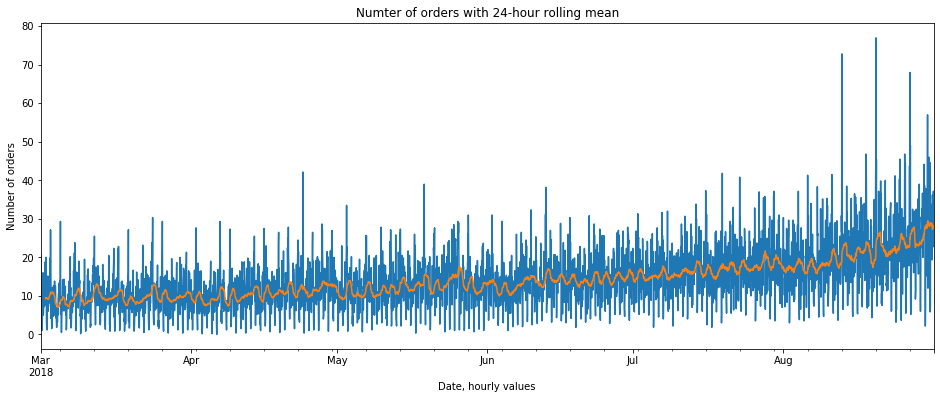

In [7]:
data['num_orders'].plot()
data.rolling(window=24).mean()['num_orders'].plot(figsize=(16, 6)) #rolling mean by one day (24 hours)
plt.xlabel('Date, hourly values')
plt.ylabel('Number of orders')
plt.title('Numter of orders with 24-hour rolling mean')
 
 


Text(0.5, 1.0, 'Residuals')

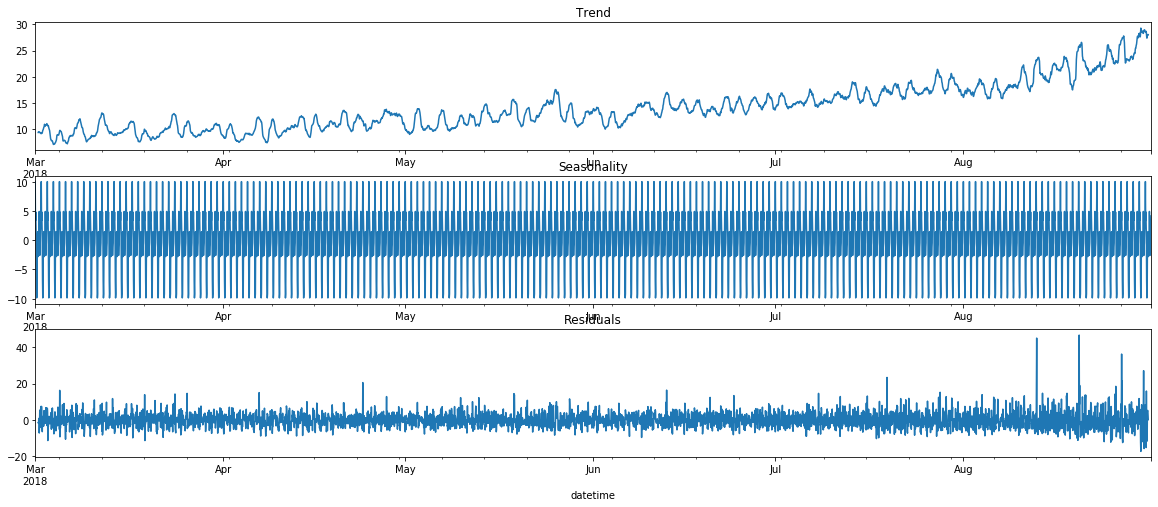

In [8]:
#exploring trends and seasonality
decomposed = seasonal_decompose(data)
plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')



In [9]:
data=data.fillna('0')

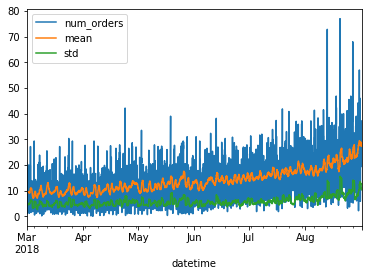

In [10]:
#checking for stationarity with plotting, but also could use Dickey-Fuller test to check for stationarity

data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot()


Data is not stationary: the mean changes over time and the standard deviation varies. 

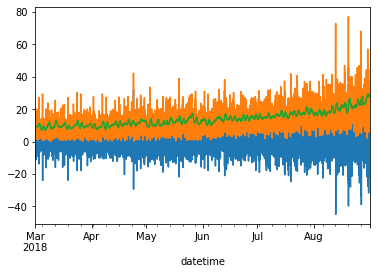

In [11]:
#Differencing the dependent variable to make data stationary
data['diff']=data['num_orders'].diff()
data['diff'].plot()
data['num_orders'].plot()

data['rolling_mean']=data.rolling(window=24).mean()['num_orders']
data['rolling_mean'].plot()

In [12]:
#Creating lags
max_lag=3
for lag in range (1, max_lag+1):
    data['lag_{}'.format(lag)]=data['num_orders'].shift(lag)

#Creating data features
data['year']=data.index.year
data['month']=data.index.month
data['day']=data.index.day
data['dayofweek']=data.index.dayofweek


Text(0.5, 1.0, 'Number of orders distribution stats by month')

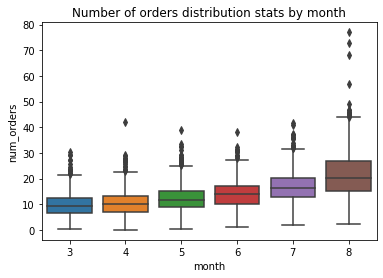

In [13]:
sns.boxplot(x=data['month'], y=data['num_orders']).set_title('Number of orders distribution stats by month')

Text(0.5, 1.0, 'Number of orders distribution stats by day of week')

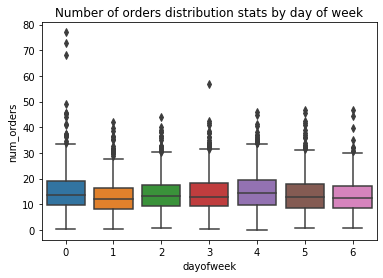

In [14]:
sns.boxplot(x=data['dayofweek'], y=data['num_orders']).set_title('Number of orders distribution stats by day of week')

Seasonality is driven by month and day of week. 

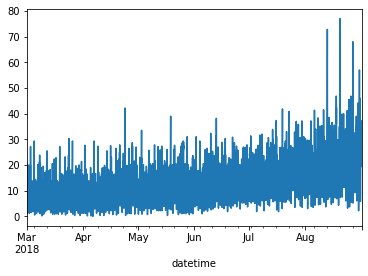

In [15]:
data['lag_1'].plot()

#Decomposition charts above show that there is seasonality and the series are driven by trend. 
Residuals are showing variability towards the end of the series

The original data is not stationary, there is seasonality and trend. To address the issues, the lags were created as well as a first-difference of the dependent variable.

# 3. Training

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print('Training set:')
print(train.head(5))
print('Test set:')
print(test.head(5))
train=train.fillna(0)
test=test.fillna(0)

Training set:
                     num_orders  mean  std      diff  rolling_mean      lag_1  \
datetime                                                                        
2018-03-01 00:00:00   20.666667   NaN  NaN       NaN           NaN        NaN   
2018-03-01 01:00:00   14.166667   NaN  NaN -6.500000           NaN  20.666667   
2018-03-01 02:00:00   11.833333   NaN  NaN -2.333333           NaN  14.166667   
2018-03-01 03:00:00   11.000000   NaN  NaN -0.833333           NaN  11.833333   
2018-03-01 04:00:00    7.166667   NaN  NaN -3.833333           NaN  11.000000   

                         lag_2      lag_3  year  month  day  dayofweek  
datetime                                                                
2018-03-01 00:00:00        NaN        NaN  2018      3    1          3  
2018-03-01 01:00:00        NaN        NaN  2018      3    1          3  
2018-03-01 02:00:00  20.666667        NaN  2018      3    1          3  
2018-03-01 03:00:00  14.166667  20.666667  2018      

In [17]:
features_train=train.drop(['num_orders'], axis=1)
target_train=train['num_orders']
features_test=test.drop(['num_orders'], axis=1)
target_test=test['num_orders']


In [18]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)


(3974, 11)
(3974,)
(442, 11)
(442,)


AR model

There is autocorrelation, residuals show trend, so the use of an autoregressive model is warranted. 


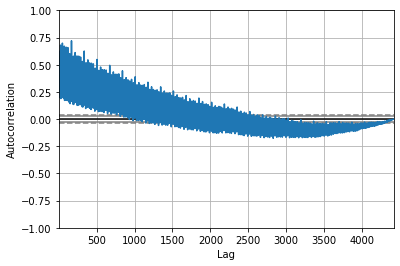

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['num_orders'])
plt.show()

In [21]:
#training AR model
from statsmodels.tsa.ar_model import AR
model = AR(target_train)
model_fit_ar = model.fit()

print('The lag value chose is: %s' % model_fit_ar.k_ar)
print('The coefficients of the model are:\n %s' % model_fit_ar.params)

/home/jovyan/.local/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning

The lag value chose is: 30
The coefficients of the model are:
 const             1.159618
L1.num_orders     0.264776
L2.num_orders     0.137871
L3.num_orders     0.054726
L4.num_orders     0.030538
L5.num_orders     0.020822
L6.num_orders    -0.018228
L7.num_orders     0.084097
L8.num_orders     0.076361
L9.num_orders    -0.074834
L10.num_orders   -0.026246
L11.num_orders    0.050198
L12.num_orders    0.034858
L13.num_orders    0.031459
L14.num_orders   -0.045892
L15.num_orders   -0.068179
L16.num_orders    0.059473
L17.num_orders    0.033976
L18.num_orders   -0.031538
L19.num_orders   -0.032874
L20.num_orders   -0.016590
L21.num_orders   -0.028163
L22.num_orders    0.090665
L23.num_orders    0.126132
L24.num_orders    0.411832
L25.num_orders   -0.001823
L26.num_orders   -0.060662
L27.num_orders   -0.068630
L28.num_orders   -0.068511
L29.num_orders   -0.008126
L30.num_orders   -0.044059
dtype: float64


In [22]:
#training AR model with 30 lags

model1 = AutoReg(target_train, lags=30)
model_fit_ar1 = model.fit()

print('The lag value chose is: %s' % model_fit_ar.k_ar)
print('The coefficients of the model are:\n %s' % model_fit_ar.params)

/home/jovyan/.local/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


The lag value chose is: 30
The coefficients of the model are:
 const             1.159618
L1.num_orders     0.264776
L2.num_orders     0.137871
L3.num_orders     0.054726
L4.num_orders     0.030538
L5.num_orders     0.020822
L6.num_orders    -0.018228
L7.num_orders     0.084097
L8.num_orders     0.076361
L9.num_orders    -0.074834
L10.num_orders   -0.026246
L11.num_orders    0.050198
L12.num_orders    0.034858
L13.num_orders    0.031459
L14.num_orders   -0.045892
L15.num_orders   -0.068179
L16.num_orders    0.059473
L17.num_orders    0.033976
L18.num_orders   -0.031538
L19.num_orders   -0.032874
L20.num_orders   -0.016590
L21.num_orders   -0.028163
L22.num_orders    0.090665
L23.num_orders    0.126132
L24.num_orders    0.411832
L25.num_orders   -0.001823
L26.num_orders   -0.060662
L27.num_orders   -0.068630
L28.num_orders   -0.068511
L29.num_orders   -0.008126
L30.num_orders   -0.044059
dtype: float64


In [23]:
#Linear Regression
model_LR=LinearRegression()
model_LR.fit(features_train, target_train)
pred_train=model_LR.predict(features_train)

The linear regression was ran on the data that includes a rolling mean and two lags. Additionally, the data was resampled for one hour. These measures are meant to make data stationary and deal with autocorrelation of residuals. 

#first difference model

In [24]:
features_train_diff=train.drop(['diff'], axis=1)
target_train_diff=train['diff']
features_test_diff=test.drop(['diff'], axis=1)
target_test_diff=test['diff']


In [25]:
model_LR=LinearRegression()
model_LR.fit(features_train_diff, target_train_diff)
pred_train_diff=model_LR.predict(features_train_diff)

# 4. Testing

In [26]:
#linear regression
LR_predict_test=model_LR.predict(features_test)
print('RMSE for the training set:', np.sqrt(mean_squared_error(target_train, pred_train)))
print('RMSE for the test set:', np.sqrt(mean_squared_error(target_test, LR_predict_test)))

RMSE for the training set: 0.3265826543131624
RMSE for the test set: 28.47903433355719


In [27]:
#first difference model, linear regression
pred_test_diff=model_LR.predict(features_test_diff)
print('RMSE for the training set:', np.sqrt(mean_squared_error(target_train_diff, pred_train_diff)))
print('RMSE for the test set:', np.sqrt(mean_squared_error(target_test_diff, pred_test_diff)))

RMSE for the training set: 0.32603498023171834
RMSE for the test set: 0.09872803653907743


In [28]:
# make prediction AR model
yhat_train = model_fit_ar1.predict(len(target_train), len(target_train), dynamic=False)
 
yhat_test=model_fit_ar1.predict(len(target_test), len(target_test), dynamic=False )

print('train_ar', np.sqrt(mean_squared_error(target_train.tail(1), yhat_train)))
print('test_ar', np.sqrt(mean_squared_error(target_test.tail(1), yhat_test)))

train_ar 1.2723977808107243
test_ar 27.6628956500857


In [29]:
# make prediction AR model
yhat_train = model_fit_ar1.predict(len(target_train), len(target_train), dynamic=True)
 
yhat_test=model_fit_ar1.predict(len(target_test), len(target_test), dynamic=True )

print('train_ar', np.sqrt(mean_squared_error(target_train.tail(1), yhat_train)))
print('test_ar', np.sqrt(mean_squared_error(target_test.tail(1), yhat_test)))

train_ar 1.2723977808107243
test_ar 27.6628956500857


The linear regression first-difference model performs better than an autoregressive model with 30 lags and better than regular regression with two lags. The linear model includes two lags to deal with stationarity as well as the rolling mean. 